In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, platform, sys
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.linear_model import SGDClassifier,LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.linear_model import LinearRegression
import string
import re
from nltk.corpus import sentiwordnet as swn
import time
import spacy
from sklearn.neighbors import KNeighborsClassifier
import en_core_web_sm

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [32]:
omdb_data = pd.read_json('../input/omdbdatajsongz/omdb-data.json/omdb-data.json', lines=True)
rotten_tomatoes = pd.read_json('../input/rottentomatoesjsongz/rotten-tomatoes.json/rotten-tomatoes.json', orient='records', lines=True)


def change_pdFrame(row, new_df):
   temp_genres = row['omdb_genres']
   counter = 0
   while counter < len(temp_genres):
       movies_row = row
       movies_row['genres'] = temp_genres[counter]
       new_df.append(movies_row)
       print(new_df)
       counter = counter + 1

movies_data = pd.merge(omdb_data, rotten_tomatoes, on=['imdb_id'])
# c = movies_data.columns
# new_df = pd.DataFrame(columns=c)
refined_movies = movies_data.omdb_genres.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('omdb_genres')
refined_movies = refined_movies.reset_index()
movies_data = movies_data.reset_index()
#movies_data = pd.merge(refined_movies, movies_data, on=['index'])
refined_movies.head()
refined_movies[['omdb_genres', 'index']].groupby('omdb_genres').sum().sort_values(by="index", ascending=False)

,index
omdb_genres,
Drama,23367913
Comedy,15306172
Action,8019195
Romance,7929966
Crime,7393260
Adventure,6214842
Thriller,5489518
Horror,5474873
Documentary,3427968


In [4]:
dummies = pd.get_dummies(refined_movies).drop_duplicates()
movies_dummies_data = pd.merge(dummies,movies_data,on=['index'])

In [5]:
STOPWORDS = stopwords.words('english')
nlp = en_core_web_sm.load()

def tokenize_text(row,col) : 
    ar = nltk.word_tokenize(row[col])
    return [i.lower() for i in ar]

def remove_stopwords(row,col) : 
    token_set = set(row[col])
    sw_set = set(STOPWORDS)
    return list(token_set.difference(sw_set))

def remove_characters_after_tokenization(tokens):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    return filtered_tokens
    
def remove_punct(row,col):
    return list(remove_characters_after_tokenization(row[col]))

def text_purity(row,col_original,col_new) : 
    original_text = len(row[col_original])
    new_text = len(row[col_new])
    return int(new_text)/int(original_text)
    
def stemming(row,col) : 
    stemmer = nltk.stem.WordNetLemmatizer()
    #stemmer = nltk.stem.snowball.PorterStemmer()
    return [stemmer.lemmatize(w) for w in row[col]]
    
def stem_word_count(row,col) : 
    return len(row[col].values.tolist())

def tag_tokens(row,col,tokens=False) : 
    doc = nlp(row[col])
    return [(t.text,t.tag_) for t in doc]

def extract_keyword_weights(row,col,NUM_TOPICS) : 
    sents=row[col]
    print(sents)
    tokens = list(map(lambda x:nltk.word_tokenize(x),sents))
    lsi = train_lsi_model_gensim(tokens,total_topics=NUM_TOPICS)
    parse_weighted_lsi_model(lsi)
    return parse_weighted_lsi_model

def feature_matrix_fit(data,vect_type,data_col) : 
    
    input_data = data[data_col].values
    if vect_type == 'count' : vectorizer = CountVectorizer(min_df=0.0,max_df=1.0,analyzer='word',ngram_range=(1,1))
    elif vect_type == 'tfidf' :   vectorizer = TfidfVectorizer(min_df=0.0,max_df=1.0,analyzer='word',ngram_range=(1,1))   
    features = vectorizer.fit_transform(input_data)
    return vectorizer,features

dataset = movies_data[['critic_percent', 'omdb_plot']]



dataset['tokens'] = dataset.apply(tokenize_text, args=('omdb_plot', ), axis=1)
dataset['tokens'] = dataset.apply(remove_punct,args=('tokens',),axis=1)
dataset['token_string'] = dataset.apply(lambda x:' '.join(x['tokens']),axis=1)
dataset['no_sw'] = dataset.apply(remove_stopwords,args=('tokens',),axis=1)
dataset['purity'] = dataset.apply(text_purity,args=('tokens','no_sw',),axis=1)
dataset['no_sw_string'] = dataset.apply(lambda x:' '.join(x['no_sw']),axis=1)
dataset['stemmed'] = dataset.apply(stemming,args=('no_sw',),axis=1)
dataset['wc_stemmed'] = dataset.apply(lambda x:len(x['stemmed']),axis=1)
dataset['stemmed_string'] = dataset.apply(lambda x:' '.join(x['stemmed']),axis=1)





/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [7]:
movies_data['string_genres'] = movies_data['omdb_genres'].apply(lambda x:str(x ) )
movies_data[['critic_percent','string_genres']].groupby('string_genres').mean().sort_values(by='critic_percent',ascending=False)

,critic_percent
string_genres,
"['Film-Noir', 'Mystery']",100.000000
"['Crime', 'Mystery', 'Sci-Fi']",100.000000
"['Animation', 'Short', 'Comedy']",100.000000
"['Animation', 'Short', 'Adventure']",100.000000
"['War', 'Action', 'Drama']",100.000000
"['Family', 'Fantasy', 'Action']",100.000000
"['Family', 'Adventure']",100.000000
"['Short', 'Action', 'Western']",100.000000
"['Documentary', 'Adventure', 'Comedy']",100.000000


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
wc_stemmed_feature = scaler.fit_transform(dataset['wc_stemmed'].values.reshape(-1,1))
dataset['wc_stemmed_scaled'] = wc_stemmed_feature
dataset = dataset.dropna()



/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
dataset.columns

Index(['critic_percent', 'omdb_plot', 'tokens', 'token_string', 'no_sw',
       'purity', 'no_sw_string', 'stemmed', 'wc_stemmed', 'stemmed_string',
       'wc_stemmed_scaled'],
      dtype='object')

(16490, 48)


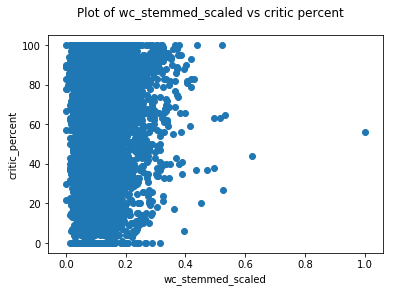

In [40]:
#movies_dummies_data
movies_final_data = pd.merge(dataset.reset_index(),movies_dummies_data,on=['index'])

cols = ['wc_stemmed','purity','critic_percent_x','wc_stemmed_scaled','stemmed_string',
 'omdb_genres_Action',
 'omdb_genres_Adult',
 'omdb_genres_Adventure',
 'omdb_genres_Animation',
 'omdb_genres_Biography',
 'omdb_genres_Comedy',
 'omdb_genres_Crime',
 'omdb_genres_Documentary',
 'omdb_genres_Drama',
 'omdb_genres_Family',
 'omdb_genres_Fantasy',
 'omdb_genres_Film-Noir',
 'omdb_genres_History',
 'omdb_genres_Horror',
 'omdb_genres_Music',
 'omdb_genres_Musical',
 'omdb_genres_Mystery',
 'omdb_genres_N/A',
 'omdb_genres_News',
 'omdb_genres_Romance',
 'omdb_genres_Sci-Fi',
 'omdb_genres_Short',
 'omdb_genres_Sport',
 'omdb_genres_Thriller',
 'omdb_genres_War',
 'omdb_genres_Western']

print(movies_final_data.shape)
# movies_final_data = movies_final_data[cols].drop_duplicates()

movies_final_data = movies_final_data.drop_duplicates(subset=['rotten_tomatoes_id'])
movies_final_data = movies_final_data[cols]
plt.suptitle('Plot of wc_stemmed_scaled vs critic percent')
plt.xlabel("wc_stemmed_scaled")
plt.ylabel("critic_percent")
plt.scatter(movies_final_data['wc_stemmed_scaled'], movies_final_data['critic_percent_x'])
#plt.scatter(movies_final_data['purity'], movies_final_data['critic_percent_x'])

In [11]:
input_cols=['wc_stemmed','purity','wc_stemmed_scaled',
 'omdb_genres_Action',
 'omdb_genres_Adult',
 'omdb_genres_Adventure',
 'omdb_genres_Animation',
 'omdb_genres_Biography',
 'omdb_genres_Comedy',
 'omdb_genres_Crime',
 'omdb_genres_Documentary',
 'omdb_genres_Drama',
 'omdb_genres_Family',
 'omdb_genres_Fantasy',
 'omdb_genres_Film-Noir',
 'omdb_genres_History',
 'omdb_genres_Horror',
 'omdb_genres_Music',
 'omdb_genres_Musical',
 'omdb_genres_Mystery',
 'omdb_genres_N/A',
 'omdb_genres_News',
 'omdb_genres_Romance',
 'omdb_genres_Sci-Fi',
 'omdb_genres_Short',
 'omdb_genres_Sport',
 'omdb_genres_Thriller',
 'omdb_genres_War',
 'omdb_genres_Western']

In [12]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso


In [13]:
## NLP PART

SIZE=500

vect,train_features = feature_matrix_fit(dataset,vect_type='tfidf',data_col='stemmed_string')
train_feature_frame = pd.DataFrame(train_features.toarray())
train_labels = movies_final_data['critic_percent_x']
train_data=movies_final_data[input_cols]

trf = train_feature_frame.reset_index()
td = train_data.reset_index()

sample_trf = trf.iloc[:SIZE,:]
sample_td= td.iloc[:SIZE,:]

#result_df=pd.merge(sample_trf,sample_td,on=['index'])
result_df=pd.concat([sample_trf,sample_td],axis=1)
result_df = result_df.drop_duplicates(subset=['index'])

xtrain, xtest, ytrain, ytest = train_test_split(result_df,train_labels[:SIZE])

score = []
alpha_values = [0.1, 0.2, 0.6, 0.75]

for alp in alpha_values :
    model = make_pipeline(StandardScaler(), PCA(100), Lasso(alpha=alp))
    model.fit(xtrain, ytrain)
    score.append(model.score(xtest, ytest))



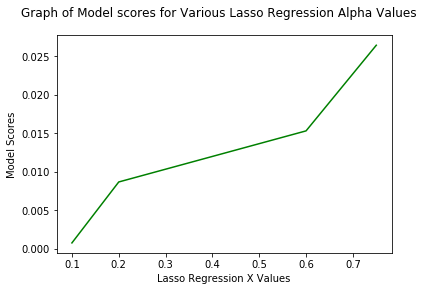

In [36]:
plt.suptitle("Graph of Model scores for Various Lasso Regression Alpha Values")
plt.xlabel('Lasso Regression X Values')
plt.ylabel('Model Scores')
plt.plot(alpha_values, score, 'g')